In [1]:
import pandas as pd
from constants import base_path
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
from collections import Counter

In [2]:
diagnosis_df_valid = pd.read_csv(f"{base_path}\\input\\release_validate_patients")

In [3]:
with open(f"{base_path}\\input\\release_evidences.json") as f:
  evidences = json.load(f)
evidences_list = []
evidences_dict = {}
evidences_en_to_code = {}
for e in evidences.keys():
  # only binary symptoms and no antecedents
  if (not evidences[e]["possible-values"]) and (not evidences[e]["is_antecedent"]):
    evidences_list.append(e)
    evidences_dict[e] = evidences[e]["question_en"]
    evidences_en_to_code[evidences[e]["question_en"]] = e
evidences_code_to_en = evidences_dict
evidences_list_en = list(evidences_en_to_code.keys())

In [4]:
with open(f"{base_path}\\input\\release_conditions.json") as f:
  disease_dict = json.load(f)
disease_list = list(disease_dict.keys())

In [24]:
def get_misses(degraded_df):
    missed_evidences_per_disease = {}
    for disease in disease_list:
        disease_df = degraded_df[degraded_df["PATHOLOGY"]==disease]

        # here, we want to count the most missed evidence per disease
        missed_evidences = []
        for e in disease_df["missed_evidence"]:
            e = ast.literal_eval(e)
            if e:
                missed_evidences.extend(e)
        missed_evidences_dict = dict(Counter(missed_evidences).most_common(10))
        missed_evidences_dict = {evidences_code_to_en[k]:missed_evidences_dict[k] for k in missed_evidences_dict}

        # hypothesis: the initial evidence is not very specific, hence the degrade in predictions
        initial_evidences_dict = dict(Counter(list(disease_df["INITIAL_EVIDENCE"])).most_common(10))
        initial_evidences_dict = {
            evidences_code_to_en[k]: initial_evidences_dict[k]
            for k in initial_evidences_dict}
        missed_evidences_per_disease[disease] = {
            "top_missed_evidences": missed_evidences_dict,
            "initial_evidences_count": initial_evidences_dict
        }
    return missed_evidences_per_disease

In [ ]:
valid_df_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\questionnaire_df.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

## Random Forest

In [5]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [7]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [8]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,1.000000
1,['Panic attack'],True,1.000000
2,['Influenza'],True,1.000000
3,['Anemia'],True,0.833333
4,['Possible NSTEMI / STEMI'],False,0.666667
...,...,...,...
132443,['Acute otitis media'],False,1.000000
132444,['Acute pulmonary edema'],True,1.000000
132445,['GERD'],True,1.000000
132446,"['Acute laryngitis', 'Acute otitis media']",False,0.400000


In [9]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire
0,Anemia,['Anemia'],True,['Anemia'],True,1.000000
1,Panic attack,['Panic attack'],True,['Panic attack'],True,1.000000
2,Influenza,['Influenza'],True,['Influenza'],True,1.000000
3,Anemia,['Anemia'],True,['Anemia'],True,0.833333
4,Boerhaave,['Boerhaave'],True,['Possible NSTEMI / STEMI'],False,0.666667
...,...,...,...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False,['Acute otitis media'],False,1.000000
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,['Acute pulmonary edema'],True,1.000000
132445,GERD,['GERD'],True,['GERD'],True,1.000000
132446,Epiglottitis,['Epiglottitis'],True,"['Acute laryngitis', 'Acute otitis media']",False,0.400000


In [10]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 11746 degraded predictions. previously correctly diagnosed but misdiagnosed using the questionnaire

is_matched_questionnaire,False,True
is_matched,,
False,12596,0
True,11746,108106


In [11]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [12]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.5506183462658008

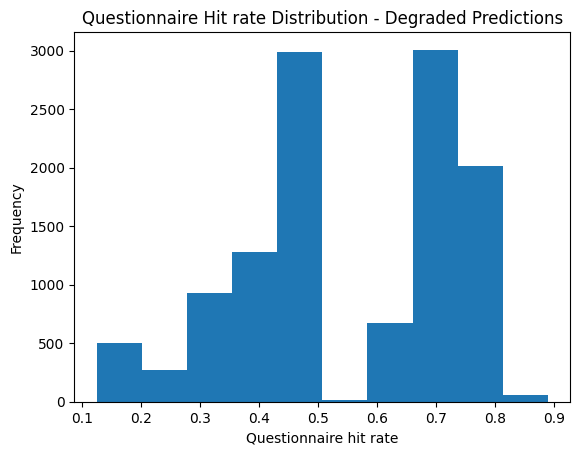

In [13]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded.jpg', bbox_inches='tight')

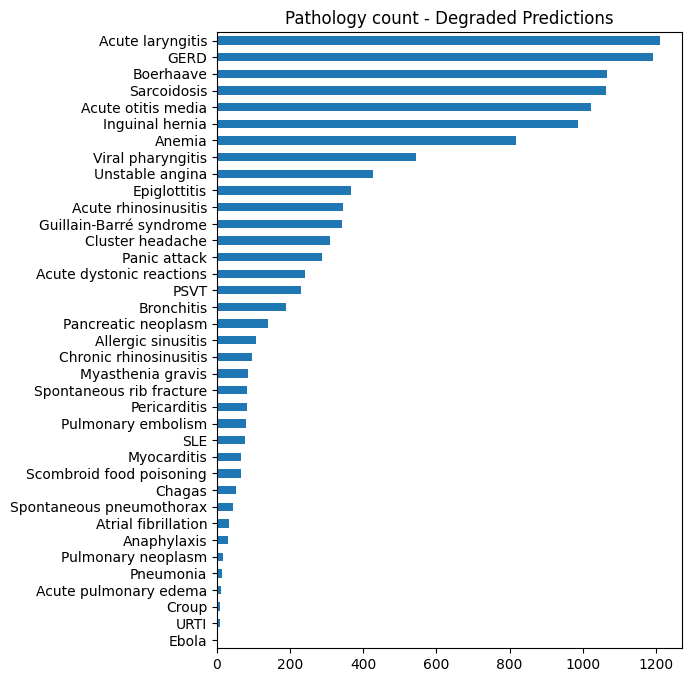

In [14]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded.jpg', bbox_inches='tight')

In [15]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_140', 'E_88', 'E_76', 'E_82', 'E_...",E_154,[]
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_75', 'E_111', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_91', 'E_181', 'E_144', 'E_50', 'E_...",E_53,[]
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89', 'E_82', 'E_76']",E_53,['E_179']
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148']",E_53,['E_210']
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_181', 'E_53']",E_201,[]
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_217', 'E_53', 'E_66']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_53']",E_91,"['E_65', 'E_190', 'E_194']"


In [16]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
4,Boerhaave,['Boerhaave'],True,['Possible NSTEMI / STEMI'],False,0.666667,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148']",E_53,['E_210']
7,Acute otitis media,['Acute otitis media'],True,['GERD'],False,0.666667,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
25,Panic attack,['Panic attack'],True,['Possible NSTEMI / STEMI'],False,0.428571,"['E_50', 'E_53', 'E_111', 'E_148', 'E_157', 'E...","['E_148', 'E_50', 'E_53']",E_148,"['E_111', 'E_177', 'E_157', 'E_171']"
37,Anemia,['Anemia'],True,"['Stable angina', 'Possible NSTEMI / STEMI']",False,0.400000,"['E_53', 'E_66', 'E_76', 'E_88', 'E_154']","['E_53', 'E_66']",E_53,"['E_76', 'E_88', 'E_154']"
41,Bronchitis,['Bronchitis'],True,['Acute otitis media'],False,0.500000,"['E_53', 'E_77', 'E_91', 'E_219']","['E_91', 'E_53']",E_91,"['E_77', 'E_219']"
...,...,...,...,...,...,...,...,...,...,...
132396,Acute rhinosinusitis,['Acute rhinosinusitis'],True,['Acute otitis media'],False,0.750000,"['E_53', 'E_91', 'E_182', 'E_201']","['E_201', 'E_91', 'E_53']",E_201,['E_182']
132404,GERD,['GERD'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_201', 'E_215']","['E_53', 'E_201']",E_53,['E_215']
132409,Acute rhinosinusitis,['Acute rhinosinusitis'],True,['Viral pharyngitis'],False,0.600000,"['E_53', 'E_91', 'E_103', 'E_182', 'E_201']","['E_53', 'E_201', 'E_91']",E_53,"['E_103', 'E_182']"
132435,Bronchitis,['Bronchitis'],True,"['Bronchitis', 'URTI']",False,0.600000,"['E_53', 'E_97', 'E_201', 'E_214', 'E_219']","['E_53', 'E_201', 'E_97']",E_53,"['E_219', 'E_214']"


In [26]:
missed_evidences_per_disease = get_misses(degraded_df)

In [27]:
missed_evidences_per_disease["Acute laryngitis"] # top 1 degrade

{'top_missed_evidences': {'Have you noticed that the tone of your voice has become deeper, softer or hoarse?': 1211},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 701,
  'Do you have a cough?': 366,
  'Do you have a fever (either felt or measured with a thermometer)?': 144}}

In [28]:
missed_evidences_per_disease["GERD"] # top 2 degrade

{'top_missed_evidences': {'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?': 857,
  'Do you have symptoms that get worse after eating?': 848,
  'Are your symptoms worse when lying down and alleviated while sitting up?': 556,
  'Have you recently thrown up blood or something resembling coffee beans?': 313,
  'Have you recently had stools that were black (like coal)?': 306},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 687,
  'Do you have a cough?': 505,
  'Are your symptoms worse when lying down and alleviated while sitting up?': 1}}

In [29]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

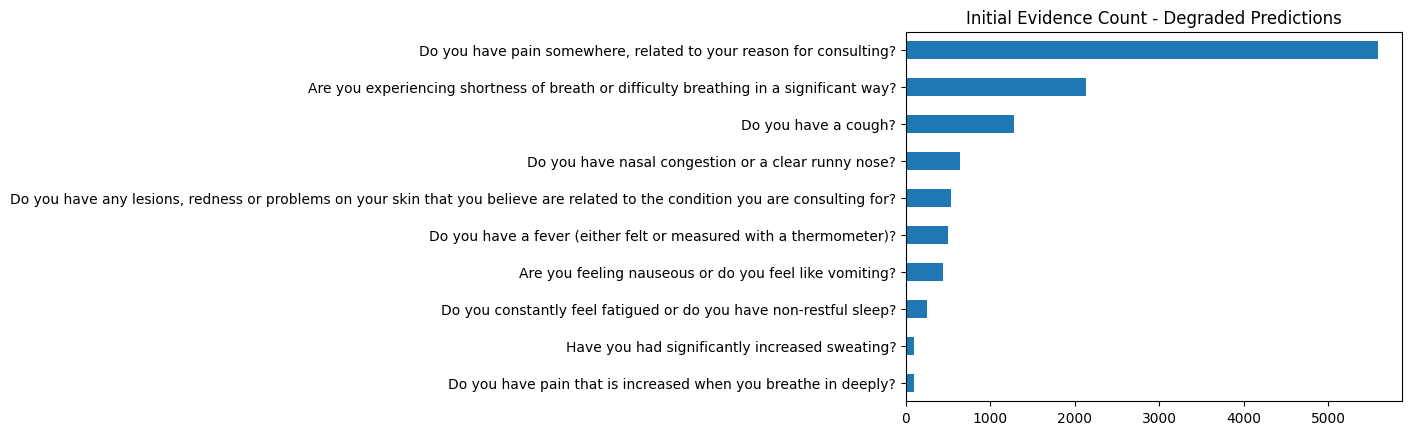

In [30]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded.jpg', bbox_inches='tight')

## Logistic Regression

In [31]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_logreg_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_logreg_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [33]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Viral pharyngitis'],True
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [28]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,1.000000
1,['Panic attack'],True,1.000000
2,['Influenza'],True,0.888889
3,['Stable angina'],False,0.500000
4,['Boerhaave'],True,1.000000
...,...,...,...
132443,['Viral pharyngitis'],True,0.666667
132444,['Acute pulmonary edema'],True,1.000000
132445,['GERD'],True,1.000000
132446,['Epiglottitis'],True,1.000000


In [34]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,PATHOLOGY_questionnaire,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,Spontaneous pneumothorax_questionnaire,Cluster headache_questionnaire,Boerhaave_questionnaire,...,Pneumonia_questionnaire,Acute rhinosinusitis_questionnaire,Chronic rhinosinusitis_questionnaire,Bronchiolitis_questionnaire,Pulmonary neoplasm_questionnaire,Possible NSTEMI / STEMI_questionnaire,Sarcoidosis_questionnaire,Pancreatic neoplasm_questionnaire,Acute pulmonary edema_questionnaire,Pericarditis_questionnaire
0,Anemia,['Anemia'],True,Anemia,['Anemia'],True,1.000000,8.240810e-06,1.306905e-07,1.250612e-06,...,3.042878e-09,0.000045,2.964278e-05,4.156345e-25,9.971866e-06,5.167661e-07,1.204016e-05,1.259412e-05,1.749385e-07,2.262037e-11
1,Panic attack,['Panic attack'],True,Panic attack,['Panic attack'],True,1.000000,1.897914e-07,5.908836e-08,8.351833e-08,...,2.557481e-07,0.000007,5.755309e-06,9.456161e-06,7.512104e-07,1.435395e-06,1.222314e-04,7.887219e-08,9.039293e-05,2.043855e-05
2,Influenza,['Influenza'],True,Influenza,['Influenza'],True,1.000000,2.834300e-08,6.821582e-11,4.139628e-10,...,2.645809e-04,0.000003,1.756812e-10,1.120161e-29,4.021024e-11,1.587541e-06,4.225942e-09,2.795075e-11,1.416207e-06,1.072775e-10
3,Anemia,['Anemia'],True,Anemia,['Anemia'],True,0.833333,6.263758e-05,4.844913e-07,1.089941e-04,...,5.563085e-06,0.000070,4.868828e-05,1.370557e-06,5.678262e-03,2.968086e-03,9.654398e-04,1.960309e-05,1.494485e-05,7.527562e-08
4,Boerhaave,['Boerhaave'],True,Boerhaave,['Possible NSTEMI / STEMI'],False,0.666667,2.444951e-03,1.512343e-01,7.862166e-01,...,1.590582e-06,0.023203,1.064213e-02,5.213560e-22,2.050258e-05,9.443614e-01,4.087747e-04,9.384200e-02,4.990391e-07,1.095001e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132443,Viral pharyngitis,['Viral pharyngitis'],True,Viral pharyngitis,['Viral pharyngitis'],True,1.000000,3.446609e-04,1.327761e-02,1.824052e-04,...,2.088886e-05,0.582114,8.255195e-01,6.266019e-12,2.593481e-04,1.940074e-05,3.897018e-04,4.993563e-03,1.110333e-06,3.782573e-05
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,Acute pulmonary edema,['Acute pulmonary edema'],True,1.000000,1.001583e-06,1.193258e-07,1.753790e-04,...,3.448623e-06,0.000027,1.457259e-05,3.020683e-25,9.024875e-04,1.140563e-04,1.114355e-03,2.156294e-07,9.999477e-01,7.069921e-02
132445,GERD,['GERD'],True,GERD,['GERD'],True,1.000000,1.085863e-03,4.905864e-06,7.766609e-07,...,2.885234e-05,0.007510,3.697064e-03,1.595498e-23,8.437705e-03,5.051341e-05,4.315803e-04,6.298523e-03,1.031900e-06,1.934437e-07
132446,Epiglottitis,['Epiglottitis'],True,Epiglottitis,['Acute otitis media'],False,0.400000,1.656958e-02,1.115823e-02,1.744926e-03,...,1.354122e-05,0.213384,6.620022e-06,3.454181e-05,1.757667e-06,9.413751e-03,3.188550e-04,1.188586e-04,1.041823e-06,1.569883e-02


In [35]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 13007 degraded predictions. previously correctly diagnosed but misdiagnosed using the questionnaire

is_matched_questionnaire,False,True
is_matched,,
False,7370,0
True,13007,112071


In [36]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [37]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.5426295791887396

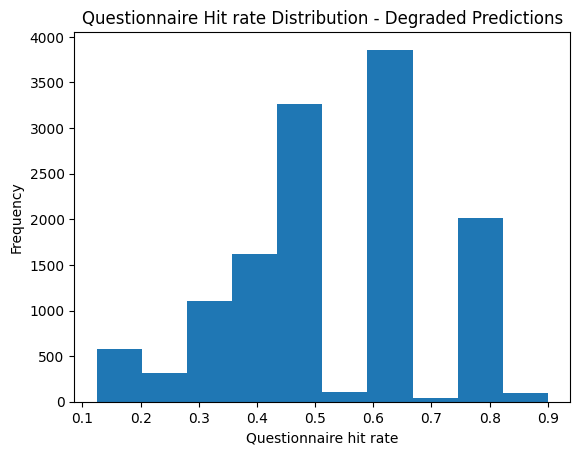

In [38]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded_logreg.jpg', bbox_inches='tight')

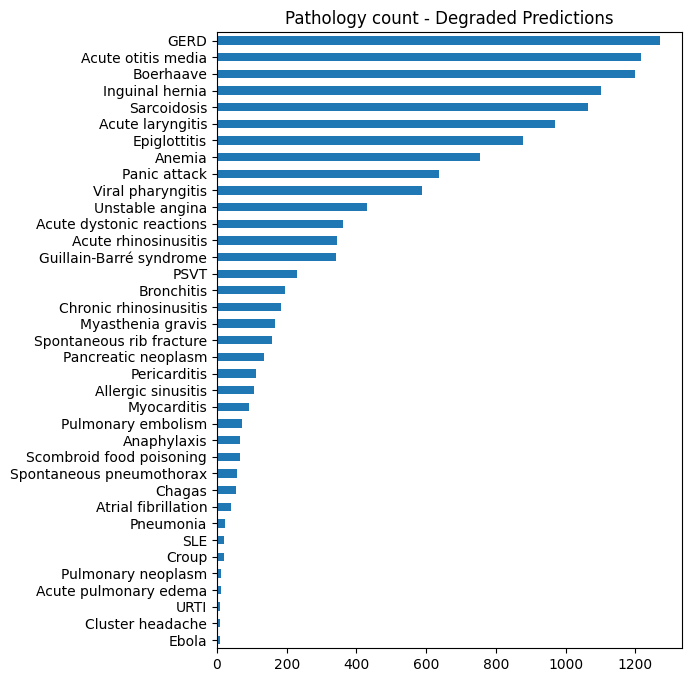

In [39]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded_logreg.jpg', bbox_inches='tight')

In [40]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_140', 'E_88', 'E_76', 'E_82', 'E_...",E_154,[]
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_75', 'E_111', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_91', 'E_181', 'E_144', 'E_50', 'E_...",E_53,[]
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89', 'E_82', 'E_76']",E_53,['E_179']
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148']",E_53,['E_210']
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_181', 'E_53']",E_201,[]
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_217', 'E_53', 'E_66']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_53']",E_91,"['E_65', 'E_190', 'E_194']"


In [41]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,PATHOLOGY_questionnaire,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,Spontaneous pneumothorax_questionnaire,Cluster headache_questionnaire,Boerhaave_questionnaire,...,Pulmonary neoplasm_questionnaire,Possible NSTEMI / STEMI_questionnaire,Sarcoidosis_questionnaire,Pancreatic neoplasm_questionnaire,Acute pulmonary edema_questionnaire,Pericarditis_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
4,Boerhaave,['Boerhaave'],True,Boerhaave,['Possible NSTEMI / STEMI'],False,0.666667,0.002445,0.151234,0.786217,...,2.050258e-05,0.944361,0.000409,0.093842,4.990391e-07,0.010950,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148']",E_53,['E_210']
7,Acute otitis media,['Acute otitis media'],True,Acute otitis media,['Viral pharyngitis'],False,0.666667,0.006430,0.011102,0.000748,...,3.572678e-02,0.005394,0.003090,0.140192,1.374205e-06,0.003936,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
25,Panic attack,['Panic attack'],True,Panic attack,['Possible NSTEMI / STEMI'],False,0.428571,0.000018,0.001385,0.035958,...,1.717668e-08,0.996397,0.000043,0.001416,5.085908e-06,0.000169,"['E_50', 'E_53', 'E_111', 'E_148', 'E_157', 'E...","['E_148', 'E_50', 'E_53']",E_148,"['E_111', 'E_177', 'E_157', 'E_171']"
37,Anemia,['Anemia'],True,Anemia,['Stable angina'],False,0.400000,0.071955,0.040633,0.049598,...,1.071338e-01,0.783297,0.053636,0.000081,1.197312e-04,0.809332,"['E_53', 'E_66', 'E_76', 'E_88', 'E_154']","['E_53', 'E_66']",E_53,"['E_76', 'E_88', 'E_154']"
41,Bronchitis,['Bronchitis'],True,Bronchitis,['Acute otitis media'],False,0.500000,0.016023,0.013809,0.001314,...,7.213918e-06,0.013470,0.000333,0.000127,1.335898e-06,0.019678,"['E_53', 'E_77', 'E_91', 'E_219']","['E_91', 'E_53']",E_91,"['E_77', 'E_219']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132396,Acute rhinosinusitis,['Acute rhinosinusitis'],True,Acute rhinosinusitis,['Acute laryngitis'],False,0.750000,0.000728,0.000008,0.000046,...,2.420360e-04,0.000070,0.000044,0.000702,1.726448e-06,0.000145,"['E_53', 'E_91', 'E_182', 'E_201']","['E_201', 'E_91', 'E_53']",E_201,['E_182']
132404,GERD,['GERD'],True,GERD,['Viral pharyngitis'],False,0.666667,0.006265,0.013074,0.000602,...,9.859647e-02,0.007109,0.003195,0.146512,1.662784e-06,0.004691,"['E_53', 'E_201', 'E_215']","['E_53', 'E_201']",E_53,['E_215']
132409,Acute rhinosinusitis,['Acute rhinosinusitis'],True,Acute rhinosinusitis,['Acute laryngitis'],False,0.600000,0.000776,0.000005,0.000079,...,1.734876e-05,0.000036,0.000040,0.000619,1.085405e-06,0.000095,"['E_53', 'E_91', 'E_103', 'E_182', 'E_201']","['E_53', 'E_201', 'E_91']",E_53,"['E_103', 'E_182']"
132435,Bronchitis,['Bronchitis'],True,Bronchitis,['URTI'],False,0.600000,0.003680,0.000090,0.000587,...,7.053725e-03,0.000337,0.001411,0.001249,1.242527e-06,0.001202,"['E_53', 'E_97', 'E_201', 'E_214', 'E_219']","['E_53', 'E_201', 'E_97']",E_53,"['E_219', 'E_214']"


In [42]:
missed_evidences_per_disease = get_misses(degraded_df)

In [43]:
missed_evidences_per_disease["GERD"] # top 1 degrade

{'top_missed_evidences': {'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?': 909,
  'Do you have symptoms that get worse after eating?': 907,
  'Are your symptoms worse when lying down and alleviated while sitting up?': 587,
  'Have you recently thrown up blood or something resembling coffee beans?': 336,
  'Have you recently had stools that were black (like coal)?': 334},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 740,
  'Do you have a cough?': 528,
  'Are your symptoms worse when lying down and alleviated while sitting up?': 2}}

In [44]:
missed_evidences_per_disease["Acute otitis media"] # top 2 degrade

{'top_missed_evidences': {'Are you more irritable or has your mood been very unstable recently?': 1217},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 454,
  'Do you have nasal congestion or a clear runny nose?': 322,
  'Do you have a cough?': 253,
  'Do you have a fever (either felt or measured with a thermometer)?': 188}}

In [45]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences_logreg.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

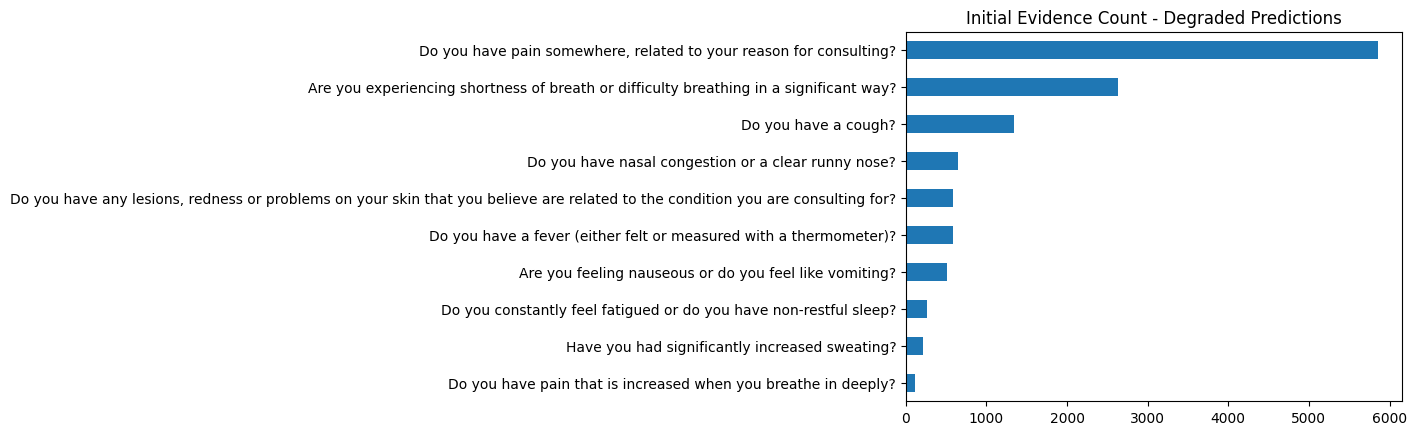

In [46]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded_logreg.jpg', bbox_inches='tight')